# Mock Spectra

Attempting to make synthetic spectra look real. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import urllib

We will try to use `urllib` to pull synthetic spectra from the Phoenix model atmosphere server. This way, we can avoid storing large raw spectrum files and keep only the processed spectra. To make life easier, we should define a function to spit out a Phoenix spectrum file URL given a set of input parameters.

In [2]:
def phoenixFileURL(Teff, logg, FeH=0.0, aFe=0.0, brand='BT-Settl', solar_abund='CIFIST2011_2015'):
    """ Create file name for a Phoenix synthetic spectrum """
    if Teff % 100.0 != 0.0:
        raise ValueError('Invalid temperature request for Phoenix server.')
    if logg not in np.arange(-0.5, 5.6, 0.5):
        raise ValueError('Invalid log(g) request for Phoenix server.')
    
    url = 'https://phoenix.ens-lyon.fr/Grids/{:s}/{:s}/SPECTRA'.format(brand, solar_abund)
    filename = 'lte{:05.1f}{:+4.1f}-{:3.1f}a{:+3.1f}.{:s}.spec.7.xz'.format(Teff/100.0, -1.0*logg, FeH, aFe, brand)
    return url, filename

Testing the Phoenix URL and file name resolver to ensure proper URL request in `urllib`.

In [3]:
phoenixFileURL(3000.0, 5.0)

('https://phoenix.ens-lyon.fr/Grids/BT-Settl/CIFIST2011_2015/SPECTRA',
 'lte030.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz')

Now try requesting the file from the Phoenix server (note: need internet access)

In [4]:
addr, filename = phoenixFileURL(3000.0, 5.0)
urllib.urlretrieve('{0}/{1}'.format(addr, filename), filename)

('lte030.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz',
 <httplib.HTTPMessage instance at 0x10c1b2cf8>)

In [6]:
spectrum = np.genfromtxt('spectra/{0}'.format(filename[:-3]), usecols=(0, 1))

Great. So, now we have properly pulled the data to the local directory structure. However, there are several complications that need to get figured out. 
 1. Data must be saved to a temporary file.
 2. Data must be unziped (unxz).
 3. All instances of Fortran doubles must be converted from D exponentials to E.
 
Now, we must trim the file as there is a significant amount of data that we don't need: everything below 3000 Å and above 4.0 microns.

In [37]:
spectrum = np.array([line for line in spectrum if 3000.0 <= line[0] <= 40000.0])
spectrum[:, 1] = 10.0**(spectrum[:, 1] - 8.0)

Let's take a look at part of the raw spectrum, say the optical.

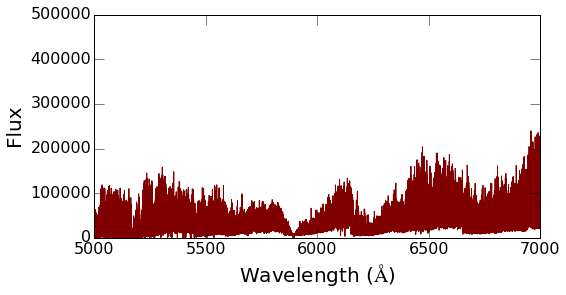

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('Wavelength ($\\AA$)', fontsize=20.0)
ax.set_ylabel('Flux', fontsize=20.0)
ax.tick_params(which='major', axis='both', length=10., labelsize=16.)
ax.set_xlim(5000., 7000.)

ax.plot(spectrum[:,0], spectrum[:,1], '-', color='#800000')

Of course, this is too high of resolution to be passable as a real spectrum. Two things need to happen: we need to degrade the resolution and add noise. To degrade the resolution, we'll convolve the spectrum with a Gaussian kernel whose FWHM is equal to the desired spectral resolution.

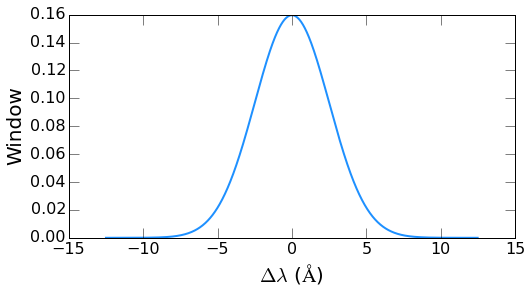

In [39]:
fwhm = 2.5  # R ~ 1000 at 5000 Å
domain = np.arange(-5.0*fwhm, 5.0*fwhm, 0.02) # note: must have same spacing as spectrum
window = np.exp(-0.5*(domain/fwhm)**2)/np.sqrt(2.0*np.pi*fwhm**2)

# visualize the window function (Kernel)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('$\\Delta\\lambda$ ($\\AA$)', fontsize=20.0)
ax.set_ylabel('Window', fontsize=20.0)
ax.tick_params(which='major', axis='both', length=10., labelsize=16.)
ax.plot(domain, window, '-', lw=2, color='#1e90ff')

Finally, we convolve the Gaussian kernel with the original spectrum, being careful to preserve the shape of the original spectrum.

In [40]:
degraded = np.convolve(spectrum[:, 1], window, mode='same')

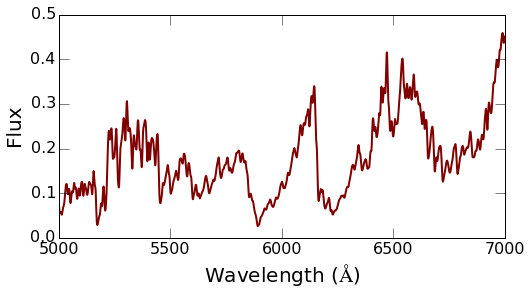

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('Wavelength ($\\AA$)', fontsize=20.0)
ax.set_ylabel('Flux', fontsize=20.0)
ax.tick_params(which='major', axis='both', length=10., labelsize=16.)
ax.set_xlim(5000., 7000.)
ax.set_ylim(0.0, 0.5)

ax.plot(spectrum[:,0], degraded/1.e7, '-', lw=2, color='#800000')

For comparison we can load an SDSS template of and M3 star, which is presumably warmer than the spectrum created here.

In [31]:
sdss_template = np.genfromtxt('../../../Projects/BlindSpot/spectra/tmp/SDSS_DR2_M3.template', usecols=(0, 1))

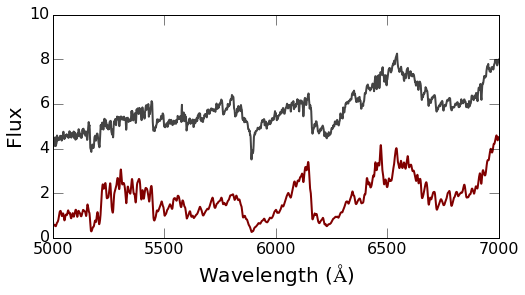

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.set_xlabel('Wavelength ($\\AA$)', fontsize=20.0)
ax.set_ylabel('Flux', fontsize=20.0)
ax.tick_params(which='major', axis='both', length=10., labelsize=16.)
ax.set_xlim(5000., 7000.)
ax.set_ylim(0., 10.)

ax.plot(sdss_template[:, 0], sdss_template[:, 1]/10. + 3.0, '-', lw=2, color='#444444')
ax.plot(spectrum[:,0], degraded/1.e6, '-', lw=2, color='#800000')